<a href="https://colab.research.google.com/github/kashperova/iasa-nlp-course/blob/main/assignment_4/RNN_CommonLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from gensim.models import Word2Vec
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn.functional import mse_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy
import torch.nn.functional as F

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Recurrent models

### Wording features description
- <b>wording</b> - target summary score
- <b>prompt_id</b> - id of prompt to summarize
- <b>text</b> - preprocessed joined text of student's summary, prompt text, prompt title
- <b>cite</b> - whether is proposed in prompt question to cite evidence from the text.
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary
- <b>fk_score</b> - Flesch-Kincaid readability score in student's summary

### Content features description
- <b>content</b> - target summary score
- <b>prompt_id</b> - id of prompt to summarize
- <b>text</b> - preprocessed joined text of student's summary, prompt text, prompt title
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>punctuation_count</b> - amount of punctuation in student's summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary

In [ ]:
content_dfrm = pd.read_csv("content_train.csv")
content_dfrm.head()

,content,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,prompt_id,text
0,0.205683,3,4,3,50,9,814d6b,the third wave was an experimentto see how peo...
1,-0.548304,1,3,2,36,6,ebad26,they would rub it up with soda to make the sme...
2,3.128928,9,13,38,142,25,3b9047,"in egypt, there were many occupations and soci..."
3,-0.210614,4,5,6,21,3,3b9047,the highest class was pharaohs these people we...
4,3.272894,23,14,30,133,18,814d6b,the third wave developed rapidly because the ...


In [ ]:
wording_dfrm =  pd.read_csv("wording_train.csv")
wording_dfrm.head()

,wording,cite,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,fk_score,prompt_id,text
0,0.380538,0,3,4,3,50,9,8.1,814d6b,the third wave was an experimentto see how peo...
1,0.506755,1,1,3,2,36,6,7.5,ebad26,they would rub it up with soda to make the sme...
2,4.231226,1,9,13,38,142,25,8.5,3b9047,"in egypt, there were many occupations and soci..."
3,-0.471415,1,4,5,6,21,3,5.3,3b9047,the highest class was pharaohs these people we...
4,3.219757,0,23,14,30,133,18,7.8,814d6b,the third wave developed rapidly because the ...


## Word2Vec Embeddings

In [ ]:
sentences = content_dfrm['text'].str.split().tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

vocab = {"<PAD>": 0, "<UNK>": 1}
embedding_matrix = [torch.zeros(100), torch.randn(100)]

for word in w2v_model.wv.index_to_key:
    vocab[word] = len(vocab)
    embedding_matrix.append(torch.FloatTensor(w2v_model.wv[word].copy()))

embedding_matrix = torch.stack(embedding_matrix)

## Custom dataset for Content

In [ ]:
class ContentDataset(Dataset):
    def __init__(self, dfrm, vocab):
        self.dfrm = dfrm
        self.vocab = vocab

    def __len__(self):
        return len(self.dfrm)

    def __getitem__(self, idx):
        text = self.dfrm.iloc[idx]['text'].split()
        text_indices = [self.vocab.get(word, self.vocab["<UNK>"]) for word in text]

        features = list(self.dfrm.iloc[idx][['mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count']].values)

        return torch.LongTensor(text_indices), torch.FloatTensor(features), torch.FloatTensor([self.dfrm.iloc[idx]['content']]), len(text_indices)

## Custom dataset for Wording

In [ ]:
class WordingDataset(Dataset):
    def __init__(self, dfrm, vocab):
        self.dfrm = dfrm
        self.vocab = vocab

    def __len__(self):
        return len(self.dfrm)

    def __getitem__(self, idx):
        text = self.dfrm.iloc[idx]['text'].split()
        text_indices = [self.vocab.get(word, self.vocab["<UNK>"]) for word in text]

        features = self.dfrm.iloc[idx][['cite', 'mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count', 'fk_score']].values

        return torch.LongTensor(text_indices), torch.FloatTensor(features), torch.FloatTensor([self.dfrm.iloc[idx]['wording']]), len(text_indices)

When creating batches, all text sequences in a batch should have the same length

In [ ]:
def collate_fn(batch):
    texts, features, targets, lengths = zip(*batch)

    max_length = max(lengths)

    texts_padded = [torch.cat([text, torch.zeros(max_length - len(text)).long()]) for text in texts]

    return torch.stack(texts_padded), torch.stack(features), torch.stack(targets)

## Modeling

I decided to create simple custom class for GRU model (bidirectional). The difference between content and wording models only in size of input features for dense layer.

In [ ]:
class ContentGRU(nn.Module):
    def __init__(self, embedding_matrix, input_dim, hidden_dim, num_layers, dropout):
        super(ContentGRU, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2 + 5, 1)

    def forward(self, x_text, x_features):
        embedded = self.embedding(x_text)
        h, _ = self.gru(embedded)
        h = h[:, -1, :]
        combined = torch.cat((h, x_features), dim=1)
        return self.fc(combined)

In [ ]:
class WordingGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(WordingGRU, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2 + 7, 1)

    def forward(self, x_text, x_features):
        embedded = self.embedding(x_text)
        h, _ = self.gru(embedded)
        h = h[:, -1, :]
        combined = torch.cat((h, x_features), dim=1)
        return self.fc(combined)

Train and validation loops (return rmse as metric)

In [ ]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for x_text, x_features, y in dataloader:
        optimizer.zero_grad()
        outputs = model(x_text, x_features)
        y = y.float()
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += mse_loss(outputs.squeeze(1), y).item()
    return (total_loss / len(dataloader)) ** 0.5

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_text, x_features, y in dataloader:
            outputs = model(x_text, x_features)
            y = y.float()
            loss = criterion(outputs, y)
            total_loss += mse_loss(outputs.squeeze(1), y).item()
    return (total_loss / len(dataloader)) ** 0.5

## Training

### Content

In [ ]:
n_splits = 4
group_kfold = GroupKFold(n_splits=n_splits)

train_losses_content, val_losses_content = [], []

best_loss = float('inf')
best_state_dict = None
folds = 0


for train_idx, val_idx in group_kfold.split(content_dfrm, content_dfrm['content'], content_dfrm['prompt_id']):
    folds += 1
    print(f"Fold: {folds}\n")
    train_data, val_data = content_dfrm.iloc[train_idx], content_dfrm.iloc[val_idx]

    train_dataset = ContentDataset(train_data, vocab)
    val_dataset = ContentDataset(val_data, vocab)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

    model = ContentGRU(embedding_matrix, input_dim=100, hidden_dim=50, num_layers=2, dropout=0.3)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    epochs = 10
    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss = validate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs} - Train RMSE: {train_loss:.4f}, Val RMSE: {val_loss:.4f}")

        train_losses_content.append(train_loss)
        val_losses_content.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state_dict_content = model.state_dict()

Fold: 1



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 1/10 - Train RMSE: 1.0755, Val RMSE: 0.9197
Epoch 2/10 - Train RMSE: 1.0704, Val RMSE: 0.9900
Epoch 3/10 - Train RMSE: 1.0751, Val RMSE: 0.9334
Epoch 4/10 - Train RMSE: 1.0713, Val RMSE: 0.9194
Epoch 5/10 - Train RMSE: 1.0828, Val RMSE: 1.0061
Epoch 6/10 - Train RMSE: 1.0600, Val RMSE: 1.2252
Epoch 7/10 - Train RMSE: 1.0652, Val RMSE: 0.9534
Epoch 8/10 - Train RMSE: 1.0781, Val RMSE: 0.9266
Epoch 9/10 - Train RMSE: 1.0793, Val RMSE: 0.9621
Epoch 10/10 - Train RMSE: 1.0638, Val RMSE: 0.9088
Fold: 2



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10 - Train RMSE: 1.0194, Val RMSE: 1.2564
Epoch 2/10 - Train RMSE: 1.0313, Val RMSE: 0.9572
Epoch 3/10 - Train RMSE: 1.0245, Val RMSE: 1.2207
Epoch 4/10 - Train RMSE: 1.0224, Val RMSE: 1.0097
Epoch 5/10 - Train RMSE: 1.0224, Val RMSE: 1.0140
Epoch 6/10 - Train RMSE: 1.0204, Val RMSE: 1.1427
Epoch 7/10 - Train RMSE: 1.0520, Val RMSE: 1.1638
Epoch 8/10 - Train RMSE: 1.0060, Val RMSE: 0.9357
Epoch 9/10 - Train RMSE: 1.0195, Val RMSE: 1.0204
Epoch 10/10 - Train RMSE: 1.0050, Val RMSE: 1.2041
Fold: 3



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10 - Train RMSE: 1.0526, Val RMSE: 0.9358
Epoch 2/10 - Train RMSE: 1.0679, Val RMSE: 0.9888
Epoch 3/10 - Train RMSE: 1.0603, Val RMSE: 0.9395
Epoch 4/10 - Train RMSE: 1.0553, Val RMSE: 0.9418
Epoch 5/10 - Train RMSE: 1.0551, Val RMSE: 0.9134
Epoch 6/10 - Train RMSE: 1.0839, Val RMSE: 1.0134
Epoch 7/10 - Train RMSE: 1.0637, Val RMSE: 1.0147
Epoch 8/10 - Train RMSE: 1.0638, Val RMSE: 1.0159
Epoch 9/10 - Train RMSE: 1.0618, Val RMSE: 0.9241
Epoch 10/10 - Train RMSE: 1.0628, Val RMSE: 0.9942
Fold: 4



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10 - Train RMSE: 1.0531, Val RMSE: 1.0911
Epoch 2/10 - Train RMSE: 1.0263, Val RMSE: 1.3413
Epoch 3/10 - Train RMSE: 1.0482, Val RMSE: 1.3298
Epoch 4/10 - Train RMSE: 1.0123, Val RMSE: 1.2538
Epoch 5/10 - Train RMSE: 1.0272, Val RMSE: 1.0076
Epoch 6/10 - Train RMSE: 1.0276, Val RMSE: 1.0773
Epoch 7/10 - Train RMSE: 1.0289, Val RMSE: 1.0387
Epoch 8/10 - Train RMSE: 1.0234, Val RMSE: 1.1587
Epoch 9/10 - Train RMSE: 1.0255, Val RMSE: 0.9982
Epoch 10/10 - Train RMSE: 1.0346, Val RMSE: 1.0493


Plotting the losses and metrics

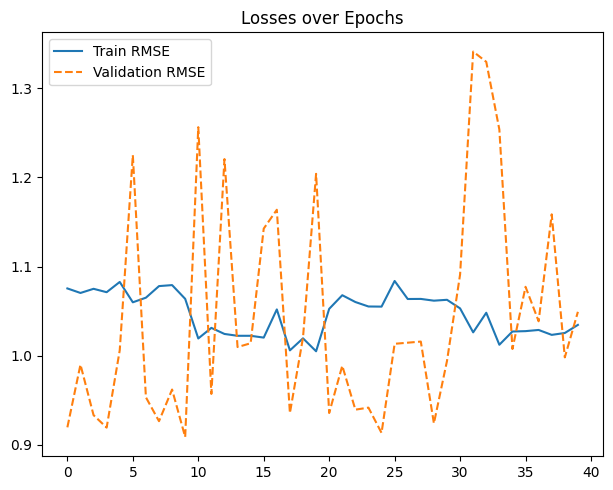

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_content, label="Train RMSE")
plt.plot(val_losses_content, label="Validation RMSE", linestyle='--')
plt.legend()
plt.title("Losses over Epochs")

plt.tight_layout()
plt.show()

Save the best model state_dict

In [ ]:
torch.save(best_state_dict_content, "content_gru.pt")

### Wording

In [ ]:
n_splits = 4
group_kfold = GroupKFold(n_splits=n_splits)

train_losses_wording, val_losses_wording = [], []

best_loss = float('inf')
best_state_dict = None
folds = 0

for train_idx, val_idx in group_kfold.split(wording_dfrm, wording_dfrm['wording'], wording_dfrm['prompt_id']):
    folds += 1
    print(f"Fold: {folds}\n")
    train_data, val_data = wording_dfrm.iloc[train_idx], wording_dfrm.iloc[val_idx]

    train_dataset = WordingDataset(train_data, vocab)
    val_dataset = WordingDataset(val_data, vocab)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

    model = WordingGRU(embedding_matrix, input_dim=100, hidden_dim=50, num_layers=2, dropout=0.5)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss = validate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs} - Train RMSE: {train_loss:.4f}, Val RMSE: {val_loss:.4f}")

        train_losses_wording.append(train_loss)
        val_losses_wording.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state_dict_wording = model.state_dict()

Fold: 1



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch 1/10 - Train RMSE: 1.7240, Val RMSE: 0.8843
Epoch 2/10 - Train RMSE: 0.9724, Val RMSE: 1.0184
Epoch 3/10 - Train RMSE: 1.0150, Val RMSE: 1.0365
Epoch 4/10 - Train RMSE: 1.0150, Val RMSE: 1.0379
Epoch 5/10 - Train RMSE: 1.0175, Val RMSE: 1.0408
Epoch 6/10 - Train RMSE: 1.0154, Val RMSE: 1.0424
Epoch 7/10 - Train RMSE: 1.0149, Val RMSE: 1.0482
Epoch 8/10 - Train RMSE: 1.0172, Val RMSE: 1.0661
Epoch 9/10 - Train RMSE: 1.0183, Val RMSE: 1.0490
Epoch 10/10 - Train RMSE: 1.0158, Val RMSE: 1.0493
Fold: 2



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10 - Train RMSE: 1.1343, Val RMSE: 1.0859
Epoch 2/10 - Train RMSE: 1.0442, Val RMSE: 0.9317
Epoch 3/10 - Train RMSE: 1.0311, Val RMSE: 0.9209
Epoch 4/10 - Train RMSE: 1.0361, Val RMSE: 0.9501
Epoch 5/10 - Train RMSE: 1.0505, Val RMSE: 0.9524
Epoch 6/10 - Train RMSE: 1.0535, Val RMSE: 0.9584
Epoch 7/10 - Train RMSE: 1.0525, Val RMSE: 0.9327
Epoch 8/10 - Train RMSE: 1.0542, Val RMSE: 0.9735
Epoch 9/10 - Train RMSE: 1.0530, Val RMSE: 0.9337
Epoch 10/10 - Train RMSE: 1.0526, Val RMSE: 0.9406
Fold: 3



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10 - Train RMSE: 1.3622, Val RMSE: 0.9651
Epoch 2/10 - Train RMSE: 1.0524, Val RMSE: 0.9674
Epoch 3/10 - Train RMSE: 1.0462, Val RMSE: 0.9629
Epoch 4/10 - Train RMSE: 1.0491, Val RMSE: 0.9543
Epoch 5/10 - Train RMSE: 1.0490, Val RMSE: 0.9800
Epoch 6/10 - Train RMSE: 1.0550, Val RMSE: 0.9891
Epoch 7/10 - Train RMSE: 1.0528, Val RMSE: 0.9806
Epoch 8/10 - Train RMSE: 1.0551, Val RMSE: 0.9580
Epoch 9/10 - Train RMSE: 1.0498, Val RMSE: 0.9676
Epoch 10/10 - Train RMSE: 1.0534, Val RMSE: 0.9680
Fold: 4



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10 - Train RMSE: 1.2746, Val RMSE: 1.4406
Epoch 2/10 - Train RMSE: 1.0208, Val RMSE: 1.4924
Epoch 3/10 - Train RMSE: 0.9980, Val RMSE: 1.4223
Epoch 4/10 - Train RMSE: 0.9799, Val RMSE: 1.3866
Epoch 5/10 - Train RMSE: 0.9762, Val RMSE: 1.3360
Epoch 6/10 - Train RMSE: 0.9798, Val RMSE: 1.3024
Epoch 7/10 - Train RMSE: 0.9828, Val RMSE: 1.3070
Epoch 8/10 - Train RMSE: 0.9781, Val RMSE: 1.3277
Epoch 9/10 - Train RMSE: 0.9781, Val RMSE: 1.3153
Epoch 10/10 - Train RMSE: 0.9758, Val RMSE: 1.2443


Plotting the losses and metrics

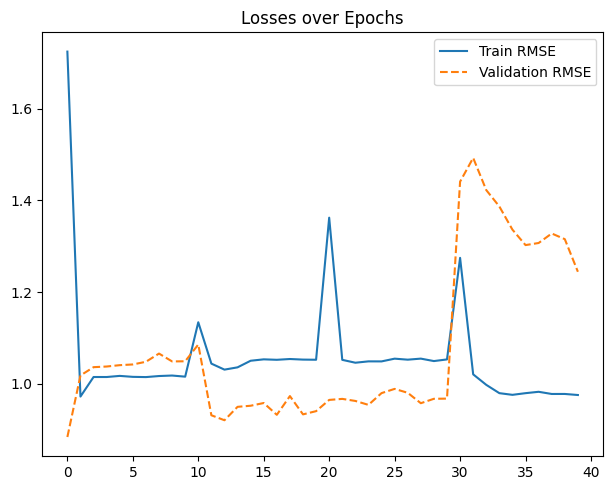

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_wording, label="Train RMSE")
plt.plot(val_losses_wording, label="Validation RMSE", linestyle='--')
plt.legend()
plt.title("Losses over Epochs")

plt.tight_layout()
plt.show()

In [ ]:
torch.save(best_state_dict_wording, "wording_gru.pt")

I want to plot final metrics on each fold

<ipython-input-144-3f52ce87f4fe>:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--o" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(folds, mean_rmse_valid, '--o', label='Mean RMSE Valid', color='blue', linestyle='dashed')


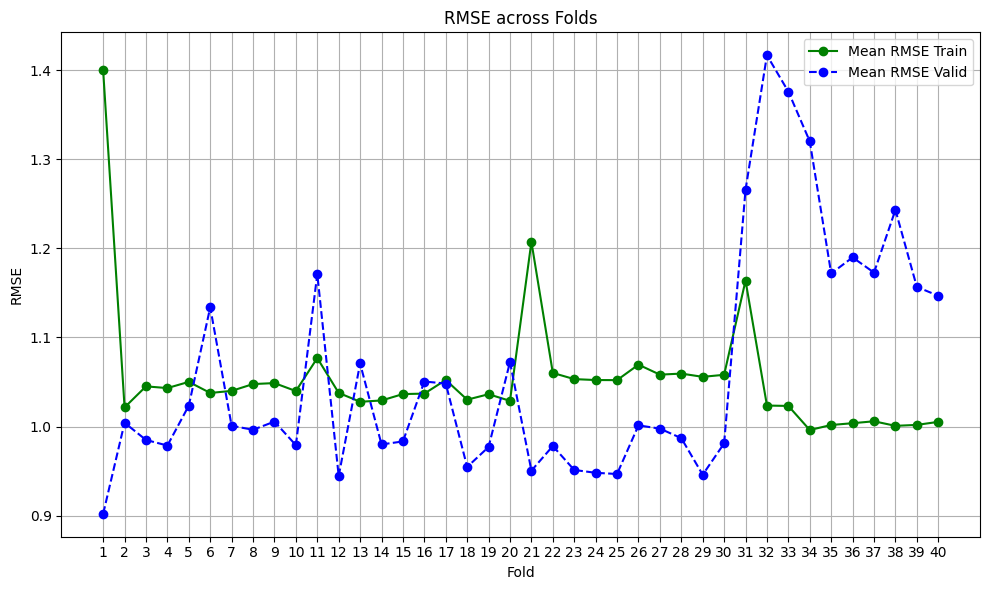

In [ ]:
mean_rmse_train = [(c + w) / 2 for c, w in zip(train_losses_content, train_losses_wording)]
mean_rmse_valid = [(c + w) / 2 for c, w in zip(val_losses_content, val_losses_wording)]

folds = list(range(1, len(mean_rmse_train) + 1))
plt.figure(figsize=(10, 6))
plt.plot(folds, mean_rmse_train, '-o', label='Mean RMSE Train', color='green')
plt.plot(folds, mean_rmse_valid, '--o', label='Mean RMSE Valid', color='blue', linestyle='dashed')

plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE across Folds')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Submission to Kaggle

<a href="">Submission notebook here</a>